In [21]:
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from scipy.io import loadmat  

In [22]:
# file_path = "C:/PhD/data_analysis/fish-size-kinematics/fish-size-kinematics/fishSizeKin_hdf5_231128.mat"
file_path = "C:/PhD/data_analysis/fish-size-kinematics/processed-data/processed-fish-size-kin-data-20231226.mat"

In [23]:
data = loadmat(file_path)

In [24]:
fdata = data['fdata']
gld = fdata['gld'][0][0]
gld_df = pd.DataFrame({name: gld[name][0, 0].flatten() for name in gld.dtype.names})

In [25]:
def calculate_jumps(group, max_stepsize):
    xdiff, ydiff = 'xdiff', 'ydiff'
    steps = np.sqrt(group[xdiff]**2 + group[ydiff]**2)
    jumps = steps > max_stepsize
    return np.where(jumps)[0]

In [26]:
gld_df.columns

Index(['ts', 'sp', 'x', 'y', 'z', 'xdiff', 'ydiff', 'angle', 'vsp', 'vx', 'vy',
       'vxdiff', 'vydiff', 'vangle', 'stim', 'ibi', 'file', 'date', 'machine',
       'turn', 'size', 'age', 'fish'],
      dtype='object')

In [27]:
def calculate_for_group(group):
    # Example: Calculate jumps

    fish_size = group['size'].iloc[0] / 10000  # Convert size units
    max_stepsize = fish_size * 3  # Calculate max_stepsize

    jumps_indices = calculate_jumps(group, max_stepsize)

    proportion_jumps = round(len(jumps_indices) / len(group), 3) if len(group) > 0 else 0

    # Additional calculations can be added here

    # Return a dictionary of results for this group
    return pd.Series ({
        # 'jumps_indices': jumps_indices,
        '#jumps': len(jumps_indices), # 'length_jumps' is the name of the column in the output csv file
        '#steps': len(group),
        'proportion_jumps': proportion_jumps,
        'fish_size': fish_size
    })

In [28]:
# Group the DataFrame
grouped_fish_df = gld_df.groupby('fish')# Apply the calculation function to each group
jumps_by_fish = grouped_fish_df.apply(calculate_for_group)
jumps_by_fish

,#jumps,#steps,proportion_jumps,fish_size
fish,,,,
7123,1437.0,43469.0,0.033,0.0112
7124,15000.0,52951.0,0.283,0.0099
7125,1168.0,33160.0,0.035,0.0064
7126,3588.0,57277.0,0.063,0.0084
10125,2390.0,42339.0,0.056,0.0104
10126,8852.0,57695.0,0.153,0.0112
27113,1485.0,46092.0,0.032,0.0112
27114,15923.0,39204.0,0.406,0.0051
27115,4351.0,35101.0,0.124,0.0057


In [36]:
def calculate_interbout_distances(group):
    xdiff, ydiff = 'xdiff', 'ydiff'
    # Calculate the distances (assuming 'xdiff' and 'ydiff' are the differences between bouts)
    distances = np.sqrt(group[xdiff]**2 + group[ydiff]**2)
    return distances

# Assuming 'gld_df' is your main DataFrame with fish, session, xdiff, ydiff
grouped = gld_df.groupby(['fish', 'turn'])

# Calculate interbout distances for each group
interbout_distances = grouped.apply(calculate_interbout_distances).reset_index(name='interbout_distance')

# Plotting histograms
unique_fish = gld_df['fish'].unique()
unique_sessions = gld_df['turn'].unique()

for fish in unique_fish:
    for session in unique_sessions:
        fish_session_data = interbout_distances[(interbout_distances['fish'] == fish) & (interbout_distances['session'] == session)]
        plt.figure(figsize=(10, 6))
        sns.histplot(fish_session_data['interbout_distance'], bins=20, kde=True)
        plt.title(f'Interbout Distance for Fish {fish} in Session {session}')
        plt.xlabel('Interbout Distance')
        plt.ylabel('Frequency')
        plt.show()


KeyError: 'session'

In [29]:
grouped_fish_turn_df = gld_df.groupby(['fish', 'turn'])
jumps_by_fish_turn = grouped_fish_turn_df.apply(calculate_for_group)

jumps_by_fish_turn

#jumps   #steps  proportion_jumps  fish_size
fish  turn                                              
7123  1      256.0  11139.0             0.023     0.0112
      2      435.0  11393.0             0.038     0.0112
      3      432.0  10585.0             0.041     0.0112
      4      314.0  10352.0             0.030     0.0112
7124  1     3825.0  13108.0             0.292     0.0099
...            ...      ...               ...        ...
30115 4      132.0   7651.0             0.017     0.0071
30116 1     3676.0  15009.0             0.245     0.0079
      2     4984.0  14891.0             0.335     0.0079
      3     2553.0  14882.0             0.172     0.0079
      4     1376.0  14663.0             0.094     0.0079

[87 rows x 4 columns]

In [9]:
# Pivot the data for plotting
fish_jumps_plotting = jumps_by_fish_turn.reset_index().pivot_table(
    index=['fish', 'turn'],#, 'fish_size', 'Age'],
    values='proportion_jumps',
    aggfunc='mean'
).reset_index()

In [10]:
# Calculate the average jumps by fish
average_jumps_by_fish = fish_jumps_plotting.groupby('fish')['proportion_jumps'].mean().reset_index()
average_jumps_by_fish['turn'] = 'Average'

In [11]:
# Combine individual and average data
fish_jumps_plotting = pd.concat([fish_jumps_plotting, average_jumps_by_fish])

In [12]:
# If necessary, convert the 'turn' column to a string type for categorical plotting
fish_jumps_plotting['turn'] = fish_jumps_plotting['turn'].astype(str)

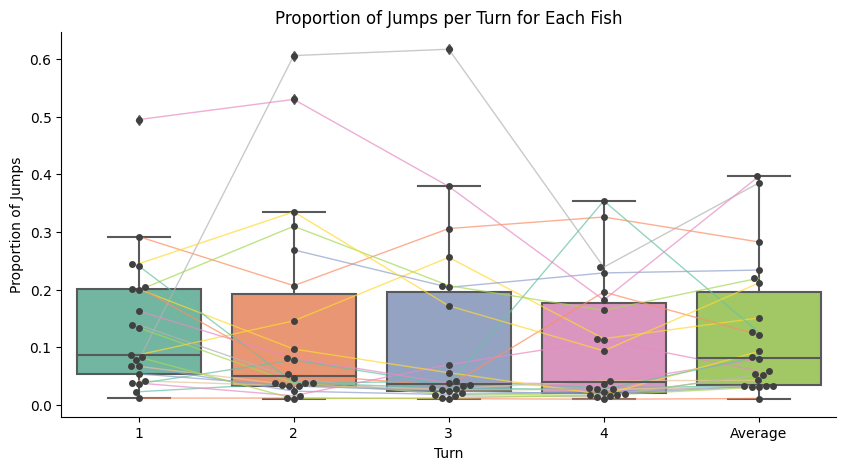

In [13]:
# Retry plotting
fig= plt.figure(figsize=(10, 5))
sns.boxplot(x='turn', y='proportion_jumps', data=fish_jumps_plotting, palette='Set2')
sns.swarmplot(x='turn', y='proportion_jumps', data=fish_jumps_plotting, color='0.25')

# Adding lines to connect the same fish across different turns
unique_fish = fish_jumps_plotting['fish'].unique()
colors = sns.color_palette('Set2', n_colors=len(unique_fish))

for idx, fish in enumerate(unique_fish):
    fish_data = fish_jumps_plotting[fish_jumps_plotting['fish'] == fish]
    fish_data_sorted = fish_data.sort_values('turn')
    plt.plot(fish_data_sorted['turn'], fish_data_sorted['proportion_jumps'], marker='', color=colors[idx], linewidth=1, alpha=0.7)

plt.title('Proportion of Jumps per Turn for Each Fish')
plt.xlabel('Turn')
plt.ylabel('Proportion of Jumps')
sns.despine()
plt.show()

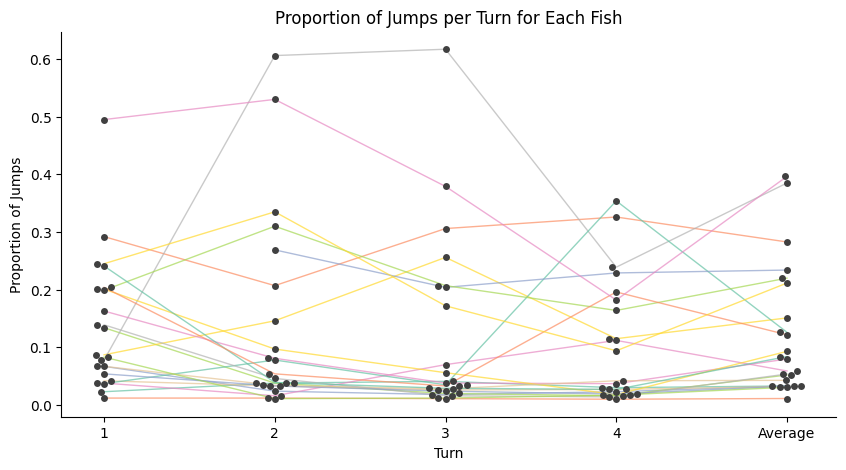

In [14]:
# Retry plotting
fig= plt.figure(figsize=(10, 5))
sns.swarmplot(x='turn', y='proportion_jumps', data=fish_jumps_plotting, color='0.25')

# Adding lines to connect the same fish across different turns
unique_fish = fish_jumps_plotting['fish'].unique()
colors = sns.color_palette('Set2', n_colors=len(unique_fish))

for idx, fish in enumerate(unique_fish):
    fish_data = fish_jumps_plotting[fish_jumps_plotting['fish'] == fish]
    fish_data_sorted = fish_data.sort_values('turn')
    plt.plot(fish_data_sorted['turn'], fish_data_sorted['proportion_jumps'], marker='', color=colors[idx], linewidth=1, alpha=0.7)

plt.title('Proportion of Jumps per Turn for Each Fish')
plt.xlabel('Turn')
plt.ylabel('Proportion of Jumps')
sns.despine()
plt.show()

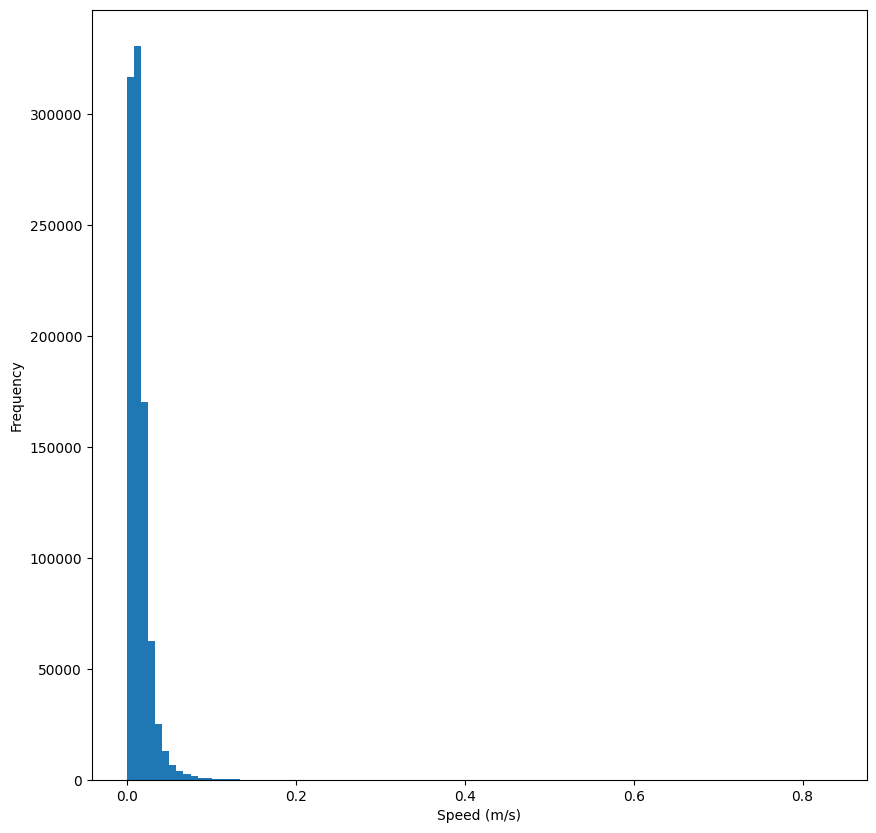

In [15]:
# plot histogram of fish speed

fig= plt.figure(figsize=(10,10))
plt.hist(gld_df['sp'], bins= 100)
plt.xlabel('Speed (m/s)')
plt.ylabel('Frequency')
plt.show()


In [16]:
# Calculate steps for each fish
def calculate_steps(group):
    ddfs = group[['x', 'y', 'z']].diff(periods=1)
    steps = np.sqrt(ddfs['x']**2 + ddfs['y']**2 + ddfs['z']**2)
    group['steps'] = steps
    return group

df = gld_df.groupby('fish').apply(calculate_steps)

# Define max step size
max_stepsize = 0.02

# Count large steps
df['large_steps'] = df['steps'] > max_stepsize
large_steps_count = df.groupby('fish')['large_steps'].sum()

print('Number of large steps for each fish:')
print(large_steps_count)


Number of large steps for each fish:
fish
7123     19840
7124     48115
7125      1438
7126     27522
10125    18229
10126    45370
27113    19580
27114     3839
27115     2593
27116     5252
28113      902
28114     3491
28115    32617
28116    16464
29113     8073
29114     7626
29115     6832
29116     6981
30113     2693
30114    28650
30115     3045
30116    41202
Name: large_steps, dtype: int64


In [17]:
# Assuming 'size' and 'age' columns exist and contain the relevant data for each fish
fish_info = df.groupby('fish').agg({'large_steps': 'sum', 'size': 'first', 'age': 'first'})
print(fish_info)

       large_steps  size  age
fish                         
7123         19840   112   28
7124         48115    99   28
7125          1438    64   28
7126         27522    84   28
10125        18229   104   30
10126        45370   112   30
27113        19580   112   25
27114         3839    51   25
27115         2593    57   25
27116         5252    88   25
28113          902    27   25
28114         3491    65   25
28115        32617    83   25
28116        16464    85   25
29113         8073    78   26
29114         7626    77   26
29115         6832    70   26
29116         6981    67   26
30113         2693    71   27
30114        28650    76   27
30115         3045    71   27
30116        41202    79   27


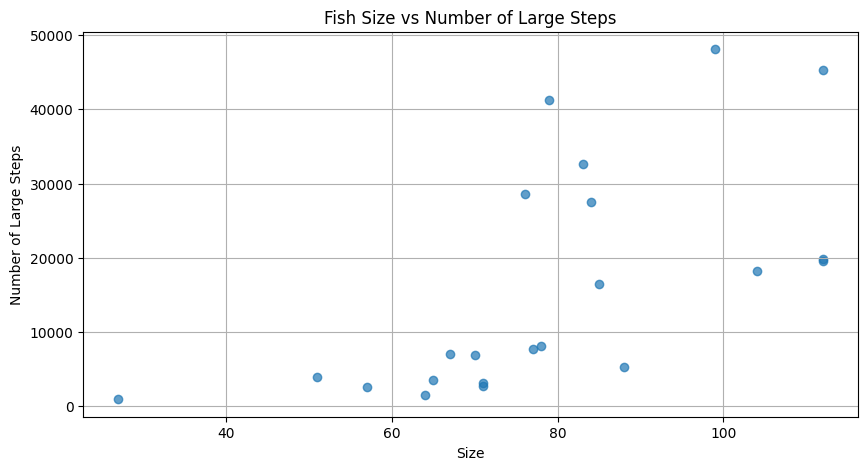

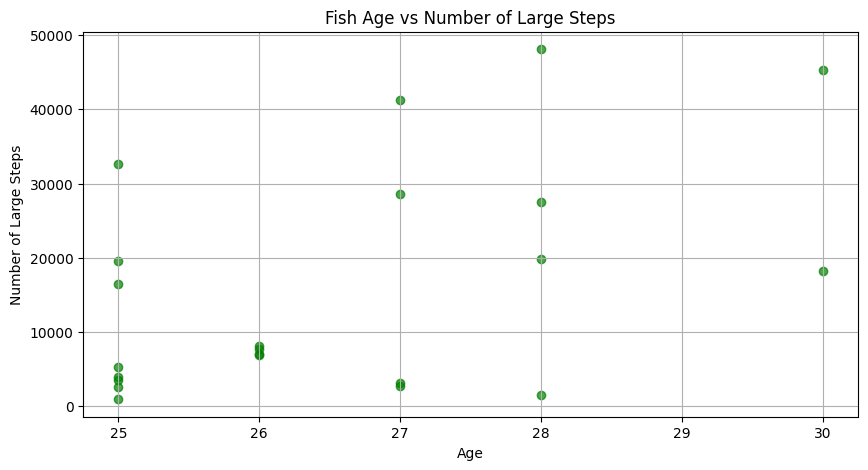

In [18]:
# Scatter plot for size vs large steps
plt.figure(figsize=(10, 5))
plt.scatter(fish_info['size'], fish_info['large_steps'], alpha=0.7)
plt.title('Fish Size vs Number of Large Steps')
plt.xlabel('Size')
plt.ylabel('Number of Large Steps')
plt.grid(True)
plt.show()

# Scatter plot for age vs large steps
plt.figure(figsize=(10, 5))
plt.scatter(fish_info['age'], fish_info['large_steps'], alpha=0.7, color='green')
plt.title('Fish Age vs Number of Large Steps')
plt.xlabel('Age')
plt.ylabel('Number of Large Steps')
plt.grid(True)
plt.show()


In [19]:
w = 10
selected_columns = ['x', 'y', 'z']

def filter_large_steps(group):
    large_step_indices = group[group['large_steps']].index
    for idx in large_step_indices:
        group.loc[idx-w:idx+w, selected_columns] = np.nan
    return group

df = df.groupby('fish').apply(filter_large_steps)